In [1]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from copy import copy
import itertools as it
from sklearn.feature_extraction.text import TfidfVectorizer
from umap import UMAP
from sklearn.manifold import TSNE
from matplotlib.patches import Arc

from tools import networkHelpers as nh

%matplotlib notebook

### HGNC Mapper

In [2]:
hgnc_mapper = nh.fetch_hgnc_mapper()

### Import Louvain Clusters

In [3]:
louvain_super = pd.read_csv('../results/weighted/louvain_clusters.txt', sep='\t')
louvain_sub = pd.read_csv('../results/weighted/louvain_small_clusters.txt', sep='\t')

louv = louvain_super.merge(louvain_sub, on='names', suffixes=['_super','_sub'])
louv.head()

,names,cluster_super,cluster_sub
0,MST1R,3,11
1,YES1,3,11
2,TYRO3,3,11
3,FGR,3,11
4,SRC,3,11


### Import Drug Targeting

In [4]:
drug_data = pd.read_excel('../data/ref/Klaeger_Science_2017 Supplementary Table 6 Selectivities.xlsx', sheet_name='CATDS target')

double_drug_targets = drug_data[drug_data['Target'].apply(lambda x: ';' in x)]
#double_drug_targets.shape

first_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[0])
second_genes = double_drug_targets['Target'].apply(lambda x: x.split(';')[1])

repaired_double_targets = double_drug_targets.drop('Target', axis=1).assign(**{'Target':first_genes})
repaired_double_targets = repaired_double_targets.append(double_drug_targets.drop('Target', axis=1).assign(**{'Target':second_genes})) 
#repaired_double_targets = repaired_double_targets[cols_to_keep]

drug_data = drug_data.drop(double_drug_targets.index).append(repaired_double_targets, sort=False)

# filter to only hgnc keys
drug_data = drug_data[drug_data.Target.isin(hgnc_mapper.keys())]

# convert to hgnc
drug_data.Target = drug_data.Target.apply(lambda x: hgnc_mapper[x])

# sort columns
drug_data = drug_data[['Target', 'Drug', 'At', 'CATDS']]
drug_data = drug_data[drug_data.Target.isin(set(louv['names']))]
drug_data.head()


,Target,Drug,At,CATDS
0,AURKA,MK-5108,0.120921,0.657165
1,CHEK1,PF-477736,0.243725,0.733257
2,FLT3,Dovitinib,0.265240,0.860803
4,MET,Capmatinib,0.337514,1.000000
5,MAPKAPK2,VX-702,0.342705,0.743594


In [5]:
kin_drug_sets = drug_data.groupby('Target').agg({'Drug':list})
kin_drug_sets = kin_drug_sets.reindex(louv.set_index('names').index)
louv = louv.merge(kin_drug_sets, on='names')
louv.Drug = louv.Drug.apply(lambda x: x if x is not np.nan else list())

### Import Understudied

In [6]:
understudied = pd.read_csv('../data/ref/dark_kinases.csv')
understudied.head()

,hgnc_id,symbol,ensembl_gene_id,class,name,uniprot_ids,kinase_com_name
0,HGNC:19038,ADCK1,ENSG00000063761,Dark,aarF domain containing kinase 1,Q86TW2,ADCK1
1,HGNC:19039,ADCK2,ENSG00000133597,Dark,aarF domain containing kinase 2,Q7Z695,ADCK2
2,HGNC:21738,ADCK5,ENSG00000173137,Dark,aarF domain containing kinase 5,Q3MIX3,ADCK5
3,HGNC:20565,ALPK2,ENSG00000198796,Dark,alpha kinase 2,Q86TB3,AlphaK2
4,HGNC:17574,ALPK3,ENSG00000136383,Dark,alpha kinase 3,Q96L96,AlphaK1


In [7]:
louv['understudied'] = louv['names'].isin(set(understudied['symbol']))
louv.head()

,names,cluster_super,cluster_sub,Drug,understudied
0,MST1R,3,11,"[Golvatinib, Crizotinib, Foretinib, MK-2461, O...",False
1,YES1,3,11,"[TG-100572, Dasatinib, TAK-901, Ibrutinib, Dan...",False
2,TYRO3,3,11,[],False
3,FGR,3,11,"[Dasatinib, Axitinib, Saracatinib, AT-9283, Da...",False
4,SRC,3,11,"[TG-100572, Dasatinib, Foretinib, Danusertib, ...",False


In [8]:
subcluster_data = copy(louv.groupby('cluster_sub').agg({'cluster_super':np.mean,'names':len, 'understudied':lambda x: int(sum(x)), 'Drug':lambda x: list(filter(lambda y: y is not np.nan, list(x)))}))
subcluster_data.Drug = subcluster_data.Drug.apply(lambda x: list(it.chain.from_iterable(x)))
subcluster_data.head()

,cluster_super,names,understudied,Drug
cluster_sub,,,,
1,4,52,7,"[Sotrastaurin, SAR-407899, Y-39983, UCN-01, AT..."
2,2,123,53,"[TG-100572, Dasatinib, Bosutinib, Danusertib, ..."
3,7,63,9,"[XL-228, SU-14813, Dovitinib, Danusertib, Milc..."
4,6,9,2,"[PF-3758309, Dinaciclib, PF-562271, PF-477736,..."
5,8,21,4,"[TG-100572, Orantinib, AT-9283, SU-14813, Silm..."


In [9]:
tfidf = TfidfVectorizer(lowercase=False, tokenizer=lambda x: x.split(','))
output = tfidf.fit_transform(raw_documents=subcluster_data['Drug'].apply(lambda x: ','.join(x)))
output

<26x218 sparse matrix of type '<class 'numpy.float64'>'
	with 1256 stored elements in Compressed Sparse Row format>

In [10]:
drug_tfidf = pd.DataFrame(output.toarray(), index=subcluster_data.index, columns=tfidf.get_feature_names())
drug_tfidf.drop('', axis=1, inplace=True)
drug_tfidf.head()

,AC-480,ACTB-1003,AEE-788,AEW-541,AMG-208,AMG-900,ARRY-380,ASP-3026,AT-13148,AT-7519,...,Vandetanib,Varlitinib,Vatalanib,Vemurafenib,Volasertib,X-396,XL-019,XL-228,XL-413,Y-39983
cluster_sub,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.022759,0.000000,0.022759,0.0,0.058917,0.0,0.037542,0.054312,0.054312,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.136552,0.137472,0.000000,0.172929
2,0.0,0.019774,0.062652,0.029661,0.0,0.076785,0.0,0.057082,0.011797,0.153365,...,0.023595,0.000000,0.0,0.000000,0.027415,0.015063,0.098870,0.153571,0.041123,0.075125
3,0.0,0.039653,0.083757,0.066088,0.0,0.091246,0.0,0.010902,0.031543,0.031543,...,0.015771,0.040274,0.0,0.084598,0.000000,0.060411,0.039653,0.079840,0.018325,0.062770
4,0.0,0.000000,0.000000,0.000000,0.0,0.137517,0.0,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.159363,0.000000,0.000000,0.151362
5,0.0,0.000000,0.068160,0.129075,0.0,0.000000,0.0,0.053229,0.000000,0.000000,...,0.000000,0.000000,0.0,0.082613,0.000000,0.000000,0.000000,0.222762,0.000000,0.000000


In [11]:
drug_score = drug_tfidf.sum(axis=1) 
drug_score

cluster_sub
1      7.965757
2     10.461685
3     10.121897
4      5.368924
5      5.869987
6      4.834819
7      5.422679
8      8.135531
9      6.951874
10     4.423684
11     9.870042
12     0.000000
13     9.215902
14     6.164346
15     5.561463
16     0.000000
17     9.899678
18     1.894866
19     2.616813
20     0.000000
21     0.000000
22     0.000000
23     1.000000
24     5.035786
25     0.000000
26     0.000000
dtype: float64

In [12]:
subcluster_data['drug_score'] = drug_score
subcluster_data.head()

,cluster_super,names,understudied,Drug,drug_score
cluster_sub,,,,,
1,4,52,7,"[Sotrastaurin, SAR-407899, Y-39983, UCN-01, AT...",7.965757
2,2,123,53,"[TG-100572, Dasatinib, Bosutinib, Danusertib, ...",10.461685
3,7,63,9,"[XL-228, SU-14813, Dovitinib, Danusertib, Milc...",10.121897
4,6,9,2,"[PF-3758309, Dinaciclib, PF-562271, PF-477736,...",5.368924
5,8,21,4,"[TG-100572, Orantinib, AT-9283, SU-14813, Silm...",5.869987


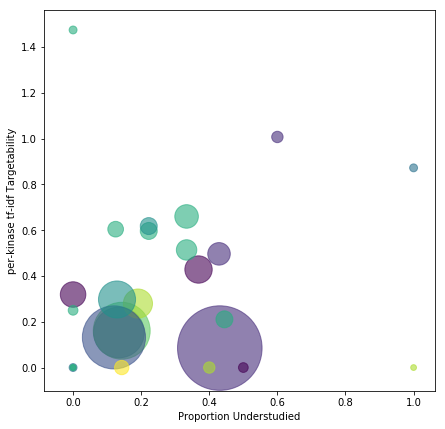

In [13]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
plt.scatter(x=subcluster_data['understudied']/subcluster_data['names'], y=subcluster_data['drug_score']/subcluster_data['names'], s=subcluster_data['names'].apply(lambda x: (np.log(x)+1)*x*10), c=subcluster_data['cluster_super'], alpha=.6)
plt.xlabel('Proportion Understudied')
plt.ylabel('per-kinase tf-idf Targetability')
#ax.set_yscale("log", basey=2)#, nonposy='clip')
#plt.ylim([-2,4])
plt.show()

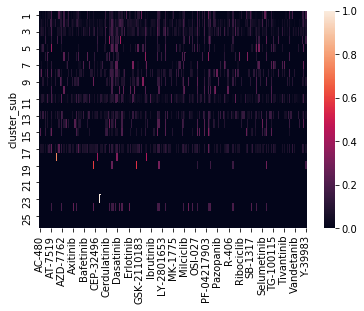

In [14]:
fig, ax = plt.subplots()
sns.heatmap(drug_tfidf)

In [15]:
idf = drug_tfidf[drug_tfidf>0].min(axis=0)

In [16]:
red = UMAP()
out = red.fit_transform(drug_tfidf)

In [17]:
blue = TSNE()
out = blue.fit_transform(drug_tfidf)

In [18]:
from sklearn.decomposition import PCA
green = PCA(n_components=2)
out = green.fit_transform(drug_tfidf)
display(green.explained_variance_ratio_)

array([0.22339631, 0.11447666])

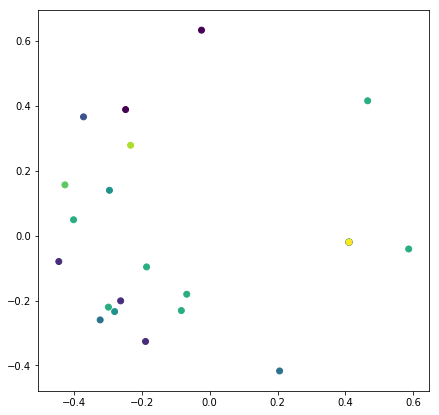

In [19]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
plt.scatter(out[:,0], out[:,1], c=subcluster_data['cluster_super'])

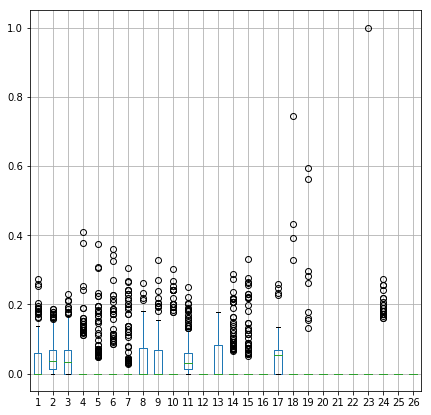

In [20]:
fig, ax = plt.subplots(figsize=(7,7), ncols=1, nrows=1)
pd.plotting.boxplot(drug_tfidf.transpose())
plt.show()

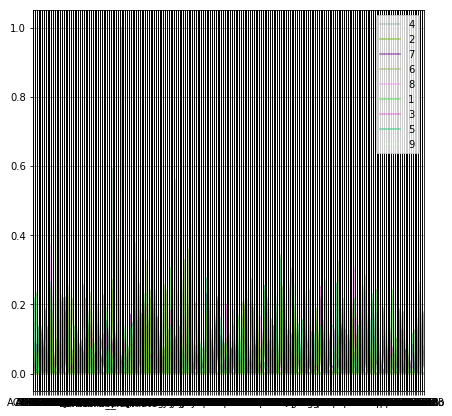

In [21]:
fig, ax = plt.subplots(figsize=(7,7), ncols=1, nrows=1)
pd.plotting.parallel_coordinates(pd.concat([drug_tfidf,subcluster_data['cluster_super']],axis=1), class_column='cluster_super', alpha=.6)
plt.show()

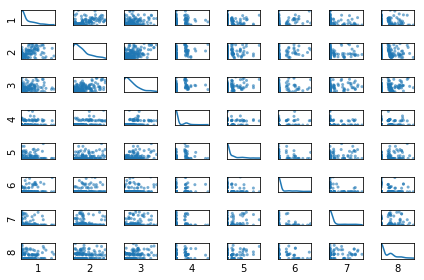

In [22]:
axes = pd.plotting.scatter_matrix(drug_tfidf.loc[1:8].transpose(), alpha=.6, diagonal='kde')
for row in axes:
    for ax in row:
        ax.xaxis.set_ticks([])
        ax.yaxis.set_ticks([])
plt.tight_layout()
plt.show()

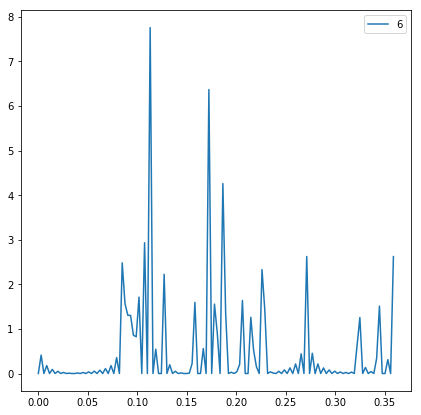

In [23]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
sns.kdeplot(data=drug_tfidf.loc[6])
plt.autoscale()
plt.show()

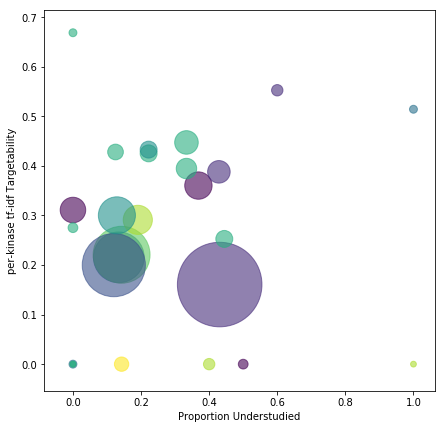

In [24]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
plt.scatter(x=subcluster_data['understudied']/subcluster_data['names'], y=np.sqrt(subcluster_data['drug_score']/subcluster_data['names']/3.3), s=subcluster_data['names'].apply(lambda x: (np.log(x)+1)*x*10), c=subcluster_data['cluster_super'], alpha=.6)
plt.xlabel('Proportion Understudied')
plt.ylabel('per-kinase tf-idf Targetability')
#ax.set_yscale("log", basey=2)#, nonposy='clip')
#plt.ylim([-2,4])
#plt.yticks([0,.25,.5,1,2])
#plt.xscale('symlog')
plt.show()

In [25]:
from matplotlib.collections import LineCollection
from scipy.spatial.distance import pdist, squareform
import matplotlib.cm as cm

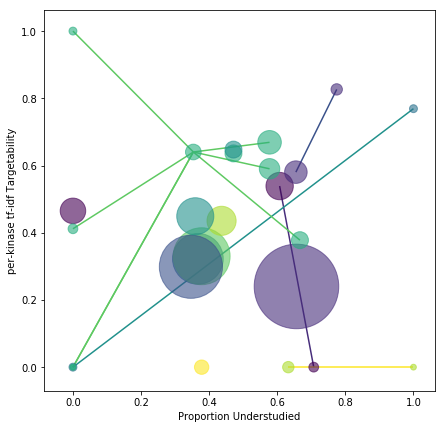

In [26]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))

under_prop = copy(subcluster_data['understudied']/subcluster_data['names'])
tfidf_clust = copy(subcluster_data['drug_score']/subcluster_data['names'])

## standardize
#under_prop = (under_prop - np.mean(under_prop))/np.std(under_prop)
#tfidf_clust = (tfidf_clust - np.mean(tfidf_clust))/np.std(tfidf_clust)

## normalize
#under_prop = (under_prop - np.min(under_prop))/(np.max(under_prop)- np.min(under_prop))
tfidf_clust = (tfidf_clust - np.min(tfidf_clust))/(np.max(tfidf_clust)- np.min(tfidf_clust))

## variance stabilize
under_prop = np.sqrt(under_prop)
tfidf_clust = np.sqrt(tfidf_clust)


plt.scatter(x=under_prop, y=tfidf_clust, s=subcluster_data['names'].apply(lambda x: (np.log(x)+1)*x*10), c=subcluster_data['cluster_super'], alpha=.6, zorder=1)
plt.xlabel('Proportion Understudied')
plt.ylabel('per-kinase tf-idf Targetability')
#ax.set_yscale("log", basey=2)#, nonposy='clip')
#plt.ylim([-2,4])
#plt.yticks([0,.25,.5,1])

for sup_ in set(subcluster_data.cluster_super.unique()):
    points_of_interest = list(zip(under_prop[subcluster_data.cluster_super == sup_], tfidf_clust[subcluster_data.cluster_super == sup_]))
    num_pres = len(points_of_interest)
    connect_to = min(1, num_pres-1)

    dist = squareform(pdist(points_of_interest, 'euclidean'))
    neighbors = np.sort(np.argsort(dist, axis=1)[:, 0:])

    points_added = set()
    coordinates = np.zeros((num_pres, connect_to, 2, 2))
    for i in range(0, num_pres):
        for j in range(0, connect_to):
            next_add = j
            if(points_of_interest[neighbors[i, next_add]][0]) in points_added:
                next_add += 1
                
            coordinates[i, j, :, 0] = np.array([points_of_interest[i][0], points_of_interest[neighbors[i, next_add]][0]])
            coordinates[i, j, :, 1] = np.array([points_of_interest[i][1], points_of_interest[neighbors[i, next_add]][1]])
            
            points_added = points_added | set([points_of_interest[neighbors[i, j]][0], points_of_interest[neighbors[i, j]][1]])
            

    # create line artists
    lines = LineCollection(coordinates.reshape((num_pres*connect_to, 2, 2)), color=cm.viridis(sup_/8.0), zorder=-1)

    ax.add_collection(lines)

#plt.yscale('logit')
#plt.xscale('logit')

#plt.autoscale()
#plt.xlim([-1,2])
#plt.ylim([-1,2])
plt.show()

### New plots

In [27]:
from collections import Counter
from collections import defaultdict
drug_counter = Counter([])
drug_super_hits = defaultdict(Counter)


for i, row in louv.iterrows():
    drug_list = row.Drug
    if drug_list is not np.nan:
        # update the superclusters seen
        # update the drug counts for each drug
        for d in set(drug_list):
            drug_super_hits[d].update([row.cluster_super])
            drug_counter.update([d])

In [28]:
drug_set = list(set(drug_data.Drug))
drug_hit_array = [drug_counter[d] for d in drug_set]
drug_super_hit_dict_array = {sup_:[drug_super_hits[d][sup_] for d in drug_set] for sup_ in set(louv.cluster_super.unique())}

drug_super_hit_normalizer = {sup_:Counter() for sup_ in set(louv.cluster_super.unique())}

for i,d in enumerate(drug_set):
    for sup_ in louv.cluster_super.unique():
        for val in range(0, drug_super_hit_dict_array[sup_][i]):
            drug_super_hit_normalizer[sup_].update([d])

In [29]:
np.max(drug_hit_array)

107

In [30]:
np.min(drug_hit_array)

1

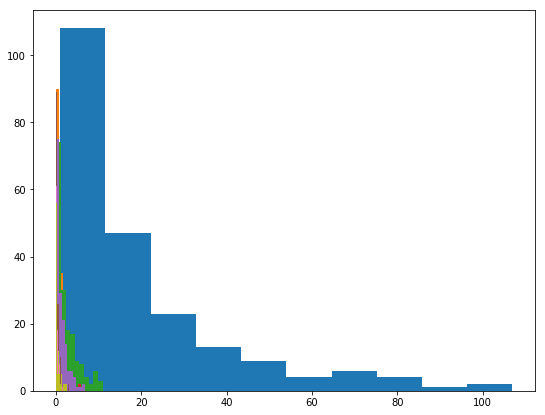

In [31]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,7))
plt.hist(drug_hit_array)
for sup_ in louv.cluster_super.unique():
    counts_normalized = np.ones_like(drug_hit_array)
    counts_normalized = np.maximum(drug_hit_array, counts_normalized)
    plt.hist(list(filter(lambda x: x > 0 ,drug_super_hit_dict_array[sup_]*np.array([drug_super_hit_normalizer[sup_][d] for d in drug_set])/counts_normalized)))
#plt.xlim([-1,120])

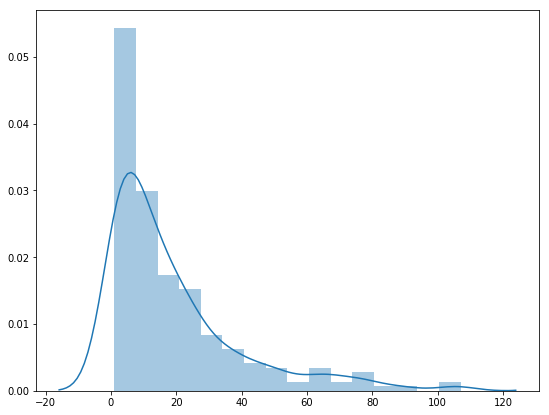

In [32]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,7))
sns.distplot(drug_hit_array)
plt.show()

([array([68.,  9., 11.,  3.,  0.,  0.,  0.,  0.,  0.,  0.]),
  array([131.,  56.,  28.,  15.,  13.,   7.,   6.,   1.,   2.,   3.]),
  array([233.,  86.,  37.,  27.,  19.,  12.,   7.,   1.,   2.,   3.]),
  array([285., 108.,  52.,  31.,  20.,  12.,   7.,   1.,   2.,   3.]),
  array([379., 117.,  61.,  32.,  20.,  12.,   7.,   1.,   2.,   3.]),
  array([482., 137.,  73.,  33.,  21.,  12.,   7.,   1.,   2.,   3.]),
  array([566., 170.,  96.,  40.,  25.,  15.,  11.,   2.,   2.,   3.]),
  array([605., 179.,  97.,  40.,  25.,  15.,  11.,   2.,   2.,   3.]),
  array([605., 179.,  97.,  40.,  25.,  15.,  11.,   2.,   2.,   3.])],
 array([ 1.,  4.,  7., 10., 13., 16., 19., 22., 25., 28., 31.]),
 <a list of 9 Lists of Patches objects>)

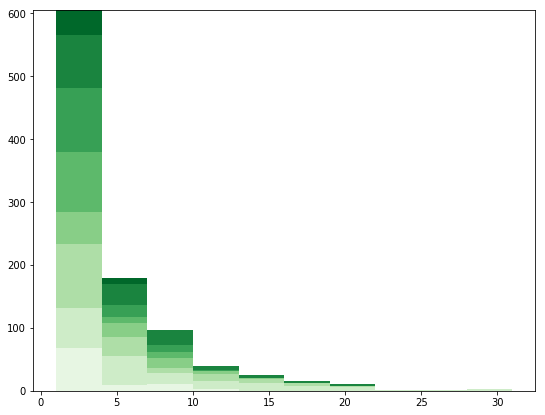

In [33]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(9,7))
plt.hist([list(filter(lambda x: x >0, drug_super_hit_dict_array[sup_])) for sup_ in set(louv.cluster_super.unique())], stacked=True, color=[cm.Greens(x/max(set(louv.cluster_super.unique()))) for x in set(louv.cluster_super.unique())])
#plt.semilogy()

In [34]:
drug_cross_super = pd.DataFrame([drug_super_hit_dict_array[sup_] for sup_ in set(louv.cluster_super.unique())])

In [35]:
louv['num_drugs'] = louv.Drug.apply(lambda x: len(x) if x is not np.nan else 0)
louv.head()

,names,cluster_super,cluster_sub,Drug,understudied,num_drugs
0,MST1R,3,11,"[Golvatinib, Crizotinib, Foretinib, MK-2461, O...",False,16
1,YES1,3,11,"[TG-100572, Dasatinib, TAK-901, Ibrutinib, Dan...",False,31
2,TYRO3,3,11,[],False,0
3,FGR,3,11,"[Dasatinib, Axitinib, Saracatinib, AT-9283, Da...",False,5
4,SRC,3,11,"[TG-100572, Dasatinib, Foretinib, Danusertib, ...",False,23


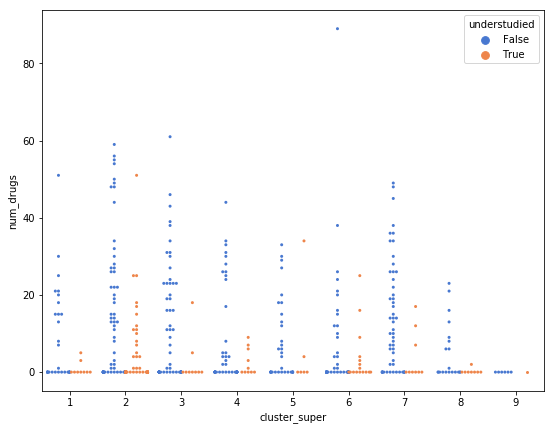

In [36]:
plt.figure(figsize=(9,7))
ax = sns.swarmplot(x='cluster_super', y="num_drugs", hue="understudied", data=louv, palette="muted", dodge=True, size=3)
plt.savefig('../viz/images/png/super_understudied_drug_swarm.png')
plt.savefig('../viz/images/pdf/super_understudied_drug_swarm.pdf')
plt.show()

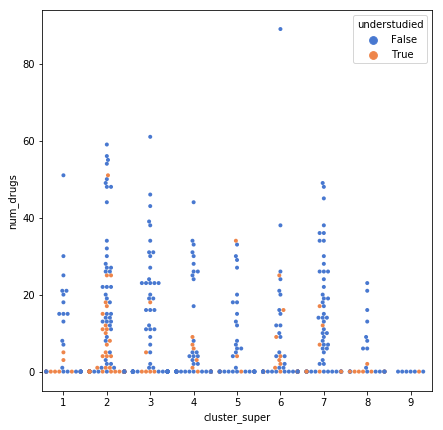

In [37]:
plt.figure(figsize=(7,7))
ax = sns.swarmplot(x='cluster_super', y="num_drugs", hue="understudied", data=louv, palette="muted", size=4)

In [38]:
selectivity_catter = lambda x: 0 if drug_counter[x] < 3 else 1 if drug_counter[x] < 10 else 2 if drug_counter[x] < 30 else 3 if drug_counter[x] < 100 else 4

In [39]:
drug_data.head()

,Target,Drug,At,CATDS
0,AURKA,MK-5108,0.120921,0.657165
1,CHEK1,PF-477736,0.243725,0.733257
2,FLT3,Dovitinib,0.265240,0.860803
4,MET,Capmatinib,0.337514,1.000000
5,MAPKAPK2,VX-702,0.342705,0.743594


In [40]:
super_mapper = louv.set_index('names')['cluster_super'].to_dict()
sub_mapper = louv.set_index('names')['cluster_sub'].to_dict()
drug_data['cluster_super'] = drug_data.Target.apply(lambda x: super_mapper[x])
drug_data['cluster_sub'] = drug_data.Target.apply(lambda x: sub_mapper[x])
drug_data['understudied'] = drug_data.Target.isin(understudied.symbol)
drug_data['selectivity_score'] = drug_data.Drug.apply(selectivity_catter)

super_drug_num_hit = drug_data.groupby(['cluster_super', 'Drug'])['Target'].agg(len).to_dict()
super_drug_num_hit = {x:{y[1]:z for y, z in super_drug_num_hit.items() if y[0]==x} for x in set(louv.cluster_super.unique())}

sub_drug_num_hit = drug_data.groupby(['cluster_sub', 'Drug'])['Target'].agg(len).to_dict()
sub_drug_num_hit = {x:{y[1]:z for y, z in sub_drug_num_hit.items() if y[0]==x} for x in set(louv.cluster_sub.unique())}


In [41]:
drug_data['num_members_hit'] = [super_drug_num_hit[x][y] for x,y in zip(drug_data.cluster_super, drug_data.Drug)]
drug_data['sub_members_hit'] = [sub_drug_num_hit[x][y] for x,y in zip(drug_data.cluster_sub, drug_data.Drug)]

In [42]:
super_size_dict = louv.groupby('cluster_super')['cluster_sub'].agg(len).to_dict()
sub_size_dict = louv.groupby('cluster_sub')['cluster_super'].agg(len).to_dict()

In [43]:
drug_data['num_members_hit'] = drug_data['num_members_hit'].apply(lambda x: x + np.random.rand()-.5)
drug_data['num_members_hit'] = drug_data['num_members_hit']/drug_data.cluster_super.map(super_size_dict)
drug_data['sub_members_hit'] = drug_data['sub_members_hit'].apply(lambda x: x + np.random.rand()-.5)
drug_data['sub_members_hit'] = drug_data['sub_members_hit']/drug_data.cluster_sub.map(sub_size_dict)

In [44]:

drug_data.head()

,Target,Drug,At,CATDS,cluster_super,cluster_sub,understudied,selectivity_score,num_members_hit,sub_members_hit
0,AURKA,MK-5108,0.120921,0.657165,2,2,False,2,0.058242,0.058708
1,CHEK1,PF-477736,0.243725,0.733257,2,2,False,3,0.095189,0.098899
2,FLT3,Dovitinib,0.265240,0.860803,3,11,False,3,0.127843,0.128265
4,MET,Capmatinib,0.337514,1.000000,3,11,False,0,0.008567,0.015838
5,MAPKAPK2,VX-702,0.342705,0.743594,7,3,False,1,0.045753,0.049735


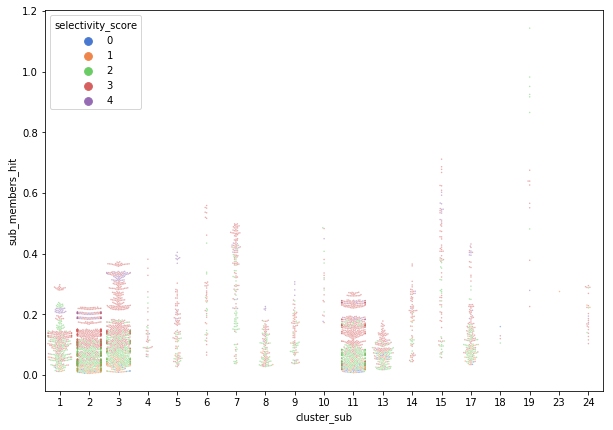

In [45]:
plt.figure(figsize=(10,7))
ax = sns.swarmplot(x='cluster_sub', y='sub_members_hit', hue="selectivity_score", data=drug_data, palette="muted", size=1.5, orient='v', alpha = .5)
#ax.set_yscale('log')

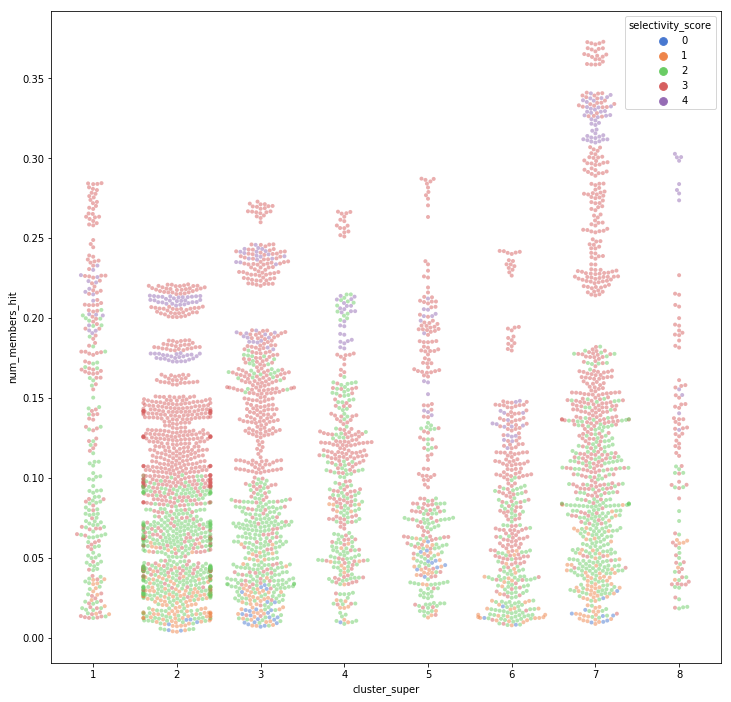

In [46]:
plt.figure(figsize=(12,12))
ax = sns.swarmplot(x='cluster_super', y='num_members_hit', hue="selectivity_score", data=drug_data, palette="muted", size=4, orient='v', alpha = .5)

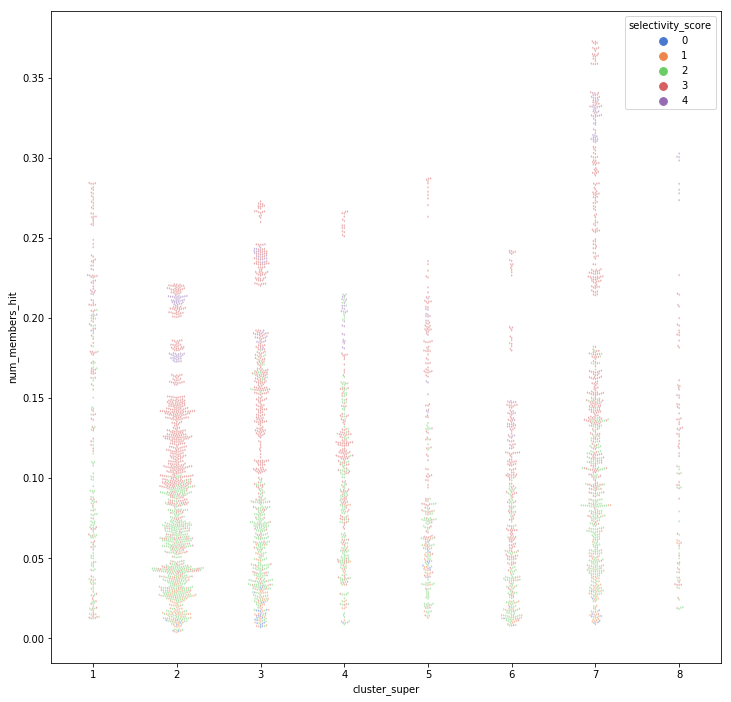

In [47]:
plt.figure(figsize=(12,12))
ax = sns.swarmplot(x='cluster_super', y='num_members_hit', hue="selectivity_score", data=drug_data, palette="muted", size=2, orient='v', alpha = .5, marker='d')
#plt.savefig('temp.pdf')

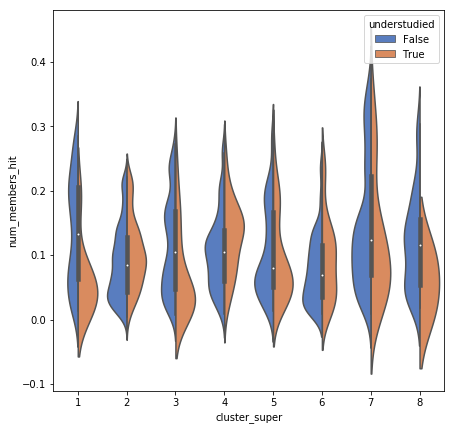

In [48]:
plt.figure(figsize=(7,7))
ax = sns.violinplot(x='cluster_super', y='num_members_hit', hue="understudied", data=drug_data, palette="muted", size=2, orient='v', alpha = .5, split=True)

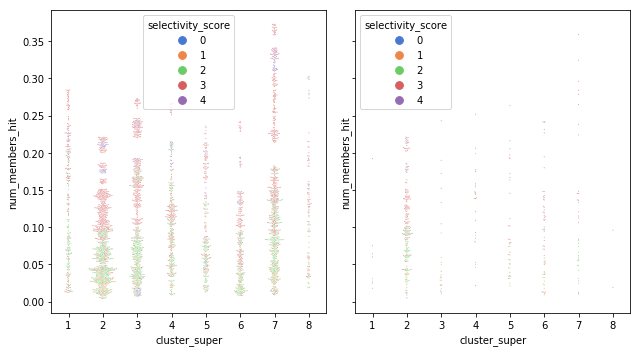

In [49]:
#sns.set(rc={'figure.figsize':(14,10)})
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(9, 5), sharey=True, sharex=True)


___ = sns.swarmplot(x='cluster_super', y='num_members_hit', hue="selectivity_score", data=drug_data[drug_data['understudied']==True], palette="muted", size=1, orient='v', alpha = .7, ax = axes[1])
__ = sns.swarmplot(x='cluster_super', y='num_members_hit', hue="selectivity_score", data=drug_data[drug_data['understudied']==False], palette="muted", size=1, orient='v', alpha = .7, ax = axes[0])
#g = sns.catplot(x="cluster_super", y="num_members_hit", kind='swarm', hue="selectivity_score", height=5, col="understudied", data=drug_data, palette="muted", alpha = 0.5, sizes=[2])
#ax = sns.swarmplot(x='cluster_super', y='num_members_hit', hue="selectivity_score", data=drug_data, palette="muted", size=2, orient='v', alpha = .5)

plt.tight_layout()
plt.show()

### Balloon Plot of Supercluster x Family

In [50]:
kmast = pd.read_excel('../data/ref/KINASESmasterlist_w_Aliases.xlsx')
kmast.head()

,Uniprot Protein,MS Gene,RNAseq Gene,RNAseq Accession,Family,Mouse Uniprot Protein,Mouse RNAseq gene,Mouse RNAseq Accession,Kinome Render Tree Name,Aliases (Conservative),...,Aliases,description,other_designations,Entrez_Symbol,Old_Name,Entrez_Synonyms,Entrez_other_designations,Unnamed: 18,Gene Symbol,Gene Symbol and Synonyms
0,AAK1,AAK1,AAK1,22848.0,Other,Aak1,Aak1,269774,AAK1,"AAK1,",...,NaN,AP2 associated kinase 1,adaptor-associated kinase 1,AAK1,AAK1,KIAA1048|MGC138170,adaptor-associated kinase 1,NaN,AAK1,AAK1
1,AAPK1,PRKAA1,PRKAA1,5562.0,CAMK,Aapk1,Prkaa1,105787,AMPK[alpha]1,"PRKAA1, AMPKa1",...,"AMPK, AMPKa1","protein kinase, AMP-activated, alpha 1 catalyt...","5'-AMP-activated protein kinase, catalytic alp...",PRKAA1,AMPKa1,AMPK|AMPKa1|MGC33776|MGC57364,"5'-AMP-activated protein kinase, catalytic alp...",NaN,PRKAA1,"AMPK, PRKAA1, AMPKa1"
2,AAPK2,PRKAA2,PRKAA2,5563.0,CAMK,Aapk2,Prkaa2,108079,AMPK[alpha]2,"PRKAA2, AMPK2, AMPKa2, PRKAA",...,"AMPK, AMPK2, AMPKa2, PRKAA","protein kinase, AMP-activated, alpha 2 catalyt...","5'-AMP-activated protein kinase, catalytic alp...",PRKAA2,AMPKa2,AMPK|AMPK2|PRKAA,"5'-AMP-activated protein kinase, catalytic alp...",NaN,PRKAA2,"AMPK2, AMPK, PRKAA, AMPKa2, PRKAA2"
3,ABL1,ABL1,ABL1,25.0,TK,Abl1,Abl1,11350,Abl,"ABL1,ABL, JTK7, bcr/abl, c-ABL, c-ABL1, v-abl",...,"ABL, JTK7, bcr/abl, c-ABL, c-ABL1, p150, v-abl","ABL proto-oncogene 1, non-receptor tyrosine ki...",Abelson tyrosine-protein kinase 1|bcr/c-abl on...,ABL1,ABL,ABL|JTK7|c-ABL|p150|v-abl,Abelson murine leukemia viral (v-abl) oncogene...,NaN,ABL1,"c-ABL1, p150, ABL, JTK7, v-abl, bcr/abl, c-ABL..."
4,ABL2,ABL2,ABL2,27.0,TK,Abl2,Abl2,11352,Arg,"ABL2,ABLL, ARG",...,"ABLL, ARG","ABL proto-oncogene 2, non-receptor tyrosine ki...","abelson-related gene protein|c-abl oncogene 2,...",ABL2,ARG,ABLL|ARG,Abelson murine leukemia viral (v-abl) oncogene...,NaN,ABL2,"ABL2, ABLL, ARG"


In [51]:
#kmast['HGNC Gene'] = kmast['MS Gene'].apply(lambda x: hgnc_mapper[x] if x in hgnc_mapper.keys() else np.nan)
kmast['HGNC Gene'] = [hgnc_mapper[x] if x in hgnc_mapper.keys()\
                      else hgnc_mapper[y] if y in hgnc_mapper.keys()\
                      else hgnc_mapper[z] if z in hgnc_mapper.keys() else None\
                      for x,y,z in zip(kmast['MS Gene'], kmast['RNAseq Gene'], kmast['Uniprot Protein'])]
kmast = kmast[~kmast['HGNC Gene'].isna()]
family_dict = kmast.set_index('MS Gene')['Family'].to_dict()

In [52]:
set(family_dict.values())

{'AGC',
 'Atypical',
 'CAMK',
 'CK1',
 'CMGC',
 'Metabolic',
 'NEK',
 'Other',
 'RGC',
 'STE',
 'TK',
 'TKL'}

In [53]:
family_dict['MAP3K20'] = 'STE'
family_dict['GRK2'] = 'AGC'
family_dict['STK26'] = 'STE'
family_dict['MAP3K21'] = 'STE'
family_dict['COQ8A'] = 'Other'
family_dict['HASPIN'] = 'Other'
family_dict['GRK3'] = 'AGC'
family_dict['COQ8B'] = 'Other'
family_dict['PAK5'] = 'STE'
family_dict['PRAG1'] = 'Other'

In [54]:
len([family_dict[x] for x in set(louv.names) if x in family_dict.keys()])

517

In [55]:
louv['family'] = louv.names.apply(lambda x: family_dict[x])

In [56]:
louv.head()

,names,cluster_super,cluster_sub,Drug,understudied,num_drugs,family
0,MST1R,3,11,"[Golvatinib, Crizotinib, Foretinib, MK-2461, O...",False,16,TK
1,YES1,3,11,"[TG-100572, Dasatinib, TAK-901, Ibrutinib, Dan...",False,31,TK
2,TYRO3,3,11,[],False,0,TK
3,FGR,3,11,"[Dasatinib, Axitinib, Saracatinib, AT-9283, Da...",False,5,TK
4,SRC,3,11,"[TG-100572, Dasatinib, Foretinib, Danusertib, ...",False,23,TK


In [57]:
family_counts = Counter(list(louv.family))
super_family_counts = louv.groupby('cluster_super')['family'].agg(list).apply(lambda x: Counter(x))
super_family_counts

cluster_super
1    {'CMGC': 3, 'TK': 19, 'AGC': 1, 'TKL': 2, 'STE...
2    {'Atypical': 10, 'TK': 6, 'CAMK': 15, 'Other':...
3    {'TK': 52, 'Atypical': 7, 'CMGC': 1, 'CAMK': 2...
4    {'AGC': 22, 'CMGC': 3, 'Metabolic': 5, 'CAMK':...
5    {'TKL': 5, 'STE': 2, 'AGC': 10, 'CMGC': 6, 'Ot...
6    {'CAMK': 23, 'Metabolic': 13, 'AGC': 7, 'STE':...
7    {'STE': 29, 'Other': 4, 'CMGC': 10, 'TKL': 7, ...
8    {'TKL': 12, 'STE': 3, 'CAMK': 3, 'Other': 7, '...
9                         {'Metabolic': 6, 'Other': 1}
Name: family, dtype: object

In [58]:
## normalize super_family_counts by size of family_counts
family_set = list(set(family_dict.values()))
for sup_ in super_family_counts.keys():
    # replace the counter with a normalized size dict
    normalized_size_dict = {}
    for fam in family_set:
        normalized_size_dict[fam] = super_family_counts[sup_][fam] / family_counts[fam]
        
    super_family_counts[sup_] = normalized_size_dict

In [59]:
super_family_cross_x, super_family_cross_size = zip(*[(x,super_family_counts[x][y]*1000) for x in super_family_counts.keys() for y in family_set])

In [60]:
family_cross_df = pd.DataFrame(index = range(0,len(family_set)*len(super_family_counts.keys())))
family_cross_df['x'] = super_family_cross_x
family_cross_df['y'] = family_set*len(super_family_counts.keys())
family_cross_df['size'] = super_family_cross_size

family_cross_df = family_cross_df[family_cross_df['size'] > 0.0]
family_cross_df.head()

,x,y,size
2,1,CMGC,48.387097
4,1,AGC,17.857143
5,1,Atypical,66.666667
6,1,STE,113.207547
7,1,TK,213.483146


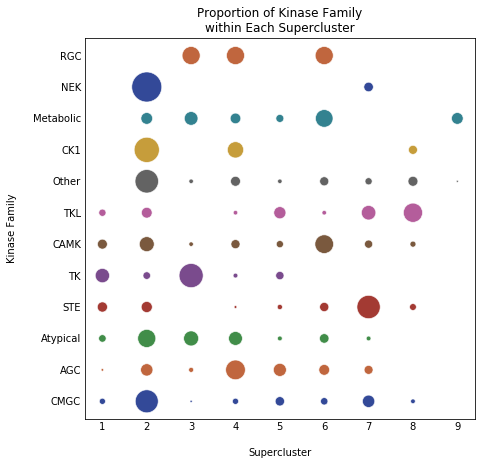

In [61]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(7,7))
sns.scatterplot(data=family_cross_df, x='x', y='y', size='size', legend=False, sizes=(0,max(family_cross_df['size'])), hue='y', palette='dark', alpha=.8)
#sns.scatterplot(data=family_cross_df, x='x', y='y', s='size', alpha=.9, hue="y")
plt.xlabel('\nSupercluster')
plt.ylabel('Kinase Family\n')
plt.tick_params(axis='both', length=0)
plt.title('Proportion of Kinase Family\nwithin Each Supercluster')

plt.savefig('../viz/images/pdf/family_cluster_division.pdf')
plt.savefig('../viz/images/png/family_cluster_division.png')

plt.show()

In [62]:
root_xy_dict = {}
biggest_clust = max(louv.groupby('cluster_sub')['names'].agg(len).to_dict().values())

for sub_ in set(louv.cluster_sub.unique()):
    sub_louv = copy(louv[louv.cluster_sub == sub_])
    sub_num_pres = len(sub_louv)
    
    nodes_to_add_x = [sub_-sub_num_pres/2.0/biggest_clust + i*1.0/biggest_clust for i in range(sub_num_pres)]
    nodes_to_add_y = [-.2 for x in nodes_to_add_x]
    
    for k,x,y in zip(sub_louv.names, nodes_to_add_x, nodes_to_add_y):
        root_xy_dict[k] = (x,y)

In [63]:
network = pd.read_csv('../data/kin/kin_unweighted.csv', sep='\t', header=None)
network.columns = ['Node1','Node2']
network['Node1'] = network['Node1'].apply(lambda x: hgnc_mapper[x])
network['Node2'] = network['Node2'].apply(lambda x: hgnc_mapper[x])
network.head()

,Node1,Node2
0,MST1R,YES1
1,TYRO3,YES1
2,FGR,SRC
3,ATR,FLT1
4,LYN,PRKCD


In [64]:
super_sub_dict = louv.groupby('cluster_super')['cluster_sub'].agg(set).to_dict()
super_sub_dict

{1: {7, 8, 21},
 2: {2, 9, 24},
 3: {11},
 4: {1, 16, 19},
 5: {13, 15},
 6: {4, 6, 10, 14, 17, 18, 22, 23, 25},
 7: {3},
 8: {5, 12, 20},
 9: {26}}

In [65]:
drug_data_ext = copy(drug_data)
sample_row = copy(drug_data.loc[0])
for sup_ in super_sub_dict.keys():
    for sub_ in super_sub_dict[sup_]:
        sample_row['Target'] = None
        sample_row['Drug'] = None
        sample_row['cluster_sub'] = sub_
        sample_row['cluster_super'] = sup_
        sample_row['num_members_hit'] = 0
        sample_row['sub_members_hit'] = 0
        
        drug_data_ext = drug_data_ext.append(sample_row)
        #sample_row

In [66]:
sub_dict = louv.set_index('names').cluster_sub.to_dict()

network_swapped = copy(network[['Node2', 'Node1']])
network_swapped.columns = ['Node1', 'Node2']
network_doubled = network.append(network_swapped, ignore_index=True)

network_doubled['n1_sub'] = network_doubled.Node1.apply(lambda x: sub_dict[x])
network_doubled['n2_sub'] = network_doubled.Node2.apply(lambda x: sub_dict[x])

In [67]:
subclust_connectivity = network_doubled.groupby(['n1_sub','n2_sub'])['Node1'].agg(len)
subclust_connectivity ={x:{y[1]:z for y, z in subclust_connectivity.items() if y[0]==x} for x in set(louv.cluster_sub.unique())}

In [79]:
for sub_ in subclust_connectivity.keys():
    # replace the counter with a normalized size dict
    normalized_size_dict = {}
    sub_connections = sum(subclust_connectivity[sub_].values())
    for connect_sub in subclust_connectivity[sub_].keys():
        normalized_size_dict[connect_sub] = subclust_connectivity[sub_][connect_sub]*1.0 / sub_connections
        
    subclust_connectivity[sub_] = normalized_size_dict
    
display(subclust_connectivity)

{1: {1: 0.37568199532346075,
  2: 0.11223694466095092,
  3: 0.11223694466095092,
  4: 0.007014809041309433,
  5: 0.014029618082618866,
  6: 0.006235385814497274,
  7: 0.003117692907248637,
  8: 0.016367887763055342,
  9: 0.010911925175370228,
  10: 0.0007794232268121592,
  11: 0.1738113795791115,
  12: 0.005455962587685114,
  13: 0.07326578332034296,
  14: 0.021044427123928296,
  15: 0.016367887763055342,
  16: 0.003117692907248637,
  17: 0.021044427123928296,
  18: 0.01792673421667966,
  19: 0.0023382696804364776,
  21: 0.0023382696804364776,
  23: 0.0015588464536243185,
  24: 0.0023382696804364776,
  26: 0.0007794232268121592},
 2: {1: 0.07430340557275543,
  2: 0.4922600619195047,
  3: 0.062435500515995876,
  4: 0.013415892672858618,
  5: 0.013931888544891642,
  6: 0.004643962848297214,
  7: 0.014447884416924666,
  8: 0.028379772961816308,
  9: 0.031991744066047476,
  10: 0.0005159958720330238,
  11: 0.10784313725490198,
  12: 0.002579979360165119,
  13: 0.062435500515995876,
  14: 0

In [69]:
sub_sup_dict = louv.groupby('cluster_sub')['cluster_super'].agg(np.mean)

In [71]:
height_dict = {sub_:.8+(int(np.abs(14-sub_) + sub_%3 + sub_%2))/10 for sub_ in range(1,27)}
#height_dict

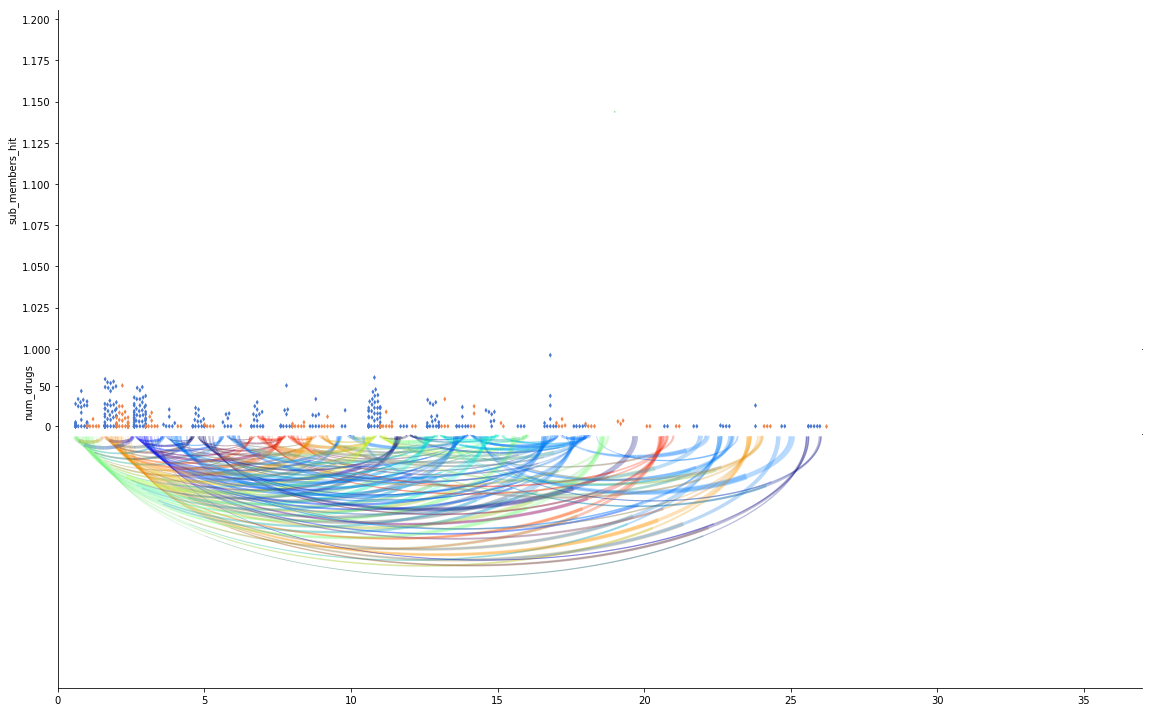

In [72]:
fig, axes = plt.subplots(ncols=1, nrows=3, figsize=(16,10), gridspec_kw = {'height_ratios':[4, 1, 3]})
g = sns.swarmplot(x='cluster_sub', y='sub_members_hit', hue="selectivity_score", data=drug_data_ext, palette="bright", size=1.75, orient='v', alpha = .6, ax=axes[0], marker='d')

g2 = sns.swarmplot(x='cluster_sub', y="num_drugs", hue="understudied", data=louv, palette="muted", dodge=True, ax = axes[1], size=3.5, marker = 'd')

axes[2].set_ylim([-50,0])
axes[2].yaxis.set_ticks([])

axes[2].grid(False)
plt.tight_layout()
fig.subplots_adjust(hspace=0)


g.set(xlim=(-1,36))
#g.set(yscale='log')
g.set(ylim=(1,None))
g.grid(False)
g.legend_.remove()
sns.despine()
g2.set(xlim=(-1,36))
#g2.set(ylim=(-3,None))
#g2.set(yscale='log')
g2.legend_.remove()
g2.grid(False)

under = set(understudied.symbol)
'''
# add nodes for each of the clusters (un-centered)
for sub_ in set(louv.cluster_sub.unique()):
    sub_louv = copy(louv[louv.cluster_sub == sub_])
    sub_nodes_x, sub_nodes_y = zip(*[root_xy_dict[k] for k in set(sub_louv.names)])
    #print(sub_nodes_x)
    
    axes[1].scatter(x=sub_nodes_x, y = sub_nodes_y, color=cm.viridis(sub_/36.0), s=.3)

'''

#total = sum(subclust_connectivity[sub_].values())
drawn = set()
cumulative = defaultdict(float)

for sub_ in subclust_connectivity.keys():
    for connect_sub in subclust_connectivity[sub_].keys():
        if connect_sub == sub_:
            continue
        
        node1_x, node1_y = (sub_-.5+1*connect_sub/26.,-.2)
        node2_x, node2_y = (connect_sub-.5+1*sub_/26.,-.2)

        num_points_between = 500#*int(np.log(np.abs(connect_sub-sub_)))

        arc_center_x = (node1_x + node2_x)/2.0
        arc_center_y = (node1_y + node2_y -.1)/2.0
        semicircle_radius = float(np.abs(node2_x - node1_x))/2.0

        arc_width_right = 10*np.sqrt(subclust_connectivity[sub_][connect_sub])
        arc_width_left = 10*np.sqrt(subclust_connectivity[connect_sub][sub_])

        line_widths = np.linspace(arc_width_right, arc_width_left, num_points_between)
        
        base_coords = np.linspace(0, 1, num_points_between)*np.pi*3/4
        #print(base_coords)
        if node1_x > node2_x:
            #continue
            x_coords = np.cos(base_coords)*semicircle_radius+arc_center_x
            #print('reverse')
        else:
            #continue
            x_coords = np.cos(base_coords+np.pi)*semicircle_radius+arc_center_x
            #base_coords = base_coords[::-1]

        #y_coords = (-np.sin(base_coords)*semicircle_radius+arc_center_y)*max(sub_,connect_sub)/18.0
        y_coords = (-np.sin(base_coords)*semicircle_radius+arc_center_y)*max(height_dict[sub_], height_dict[connect_sub])

        points = np.array([x_coords, y_coords]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        color_right = list(cm.jet_r(sub_sup_dict[sub_]/8.))
        color_left = list(cm.jet_r(sub_sup_dict[connect_sub]/8.))
        color_left[3] = 0 # set to transparent at end
        
        color_coords = np.linspace(0.0, 1.0, num_points_between)
        
        color_coords = list(zip(*[list((color_left[i]-color_right[i])*color_coords*.4+color_right[i]) if i < 3 else list((color_left[i]-color_right[i])*color_coords+color_right[i]) for i in range(4)]))
        #print(color_coords[0],color_coords[150],color_coords[290],color_coords[499])
        
    
        lc = LineCollection(segments, linewidths=line_widths,color=color_coords, alpha=.3)#, linestyles='-')


        axes[2].add_collection(lc)
    #break


axes[2].set_xlim([0,37])        

#plt.savefig('subcluster_sequoia_logbranches_logtrunk3.pdf', orientation='landscape')
plt.show()
#axes[0].set_xlim([0,5])


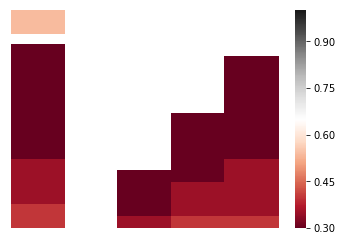

In [73]:
import math

#sns.barplot()
k = 6
sub_louv = copy(louv[louv.cluster_sub == k])
max_num_drugs = max(sub_louv.num_drugs)

num_under_local = np.sum(sub_louv.understudied&(sub_louv.num_drugs > 0))
num_not_under_local = np.sum((~sub_louv.understudied)&(sub_louv.num_drugs > 0))
num_studied = max(np.sum(sub_louv.understudied), np.sum(~sub_louv.understudied))

#local_heat_mat = np.zeros((len(sub_louv),math.ceil(max_num_drugs/10))) 
local_heat_mat = np.ones((num_under_local+num_not_under_local,max_num_drugs+3)) 
#alpha_heat_mat = np.zeros((num_drugged+num_under_local+num_not_under_local,max_num_drugs)) 
#display(local_heat_mat)
#display(sub_louv.sort_values(by='num_drugs', ascending=False))
for understudied_value in [True, False]:
    local_sub_louv = sub_louv[(sub_louv.understudied == understudied_value) & (sub_louv.num_drugs>0)]
    reverse=understudied_value
    offset = 0 if understudied_value else - num_under_local//2 - num_not_under_local//2
    for ind,row in local_sub_louv.sort_values(by=['num_drugs'], ascending= not understudied_value).reset_index().iterrows():
        sorted_deltas = [.9 - ds/10.0 for ds in sorted([selectivity_catter(d) for d in row['Drug']], reverse=not understudied_value)] if row['Drug'] is not np.nan else 0
        to_start = 0 if row['understudied'] else max_num_drugs+3-row['num_drugs'] 
        to_stop = row['num_drugs'] if row['understudied'] else max_num_drugs+3
        #print(to_start, to_stop)
        local_heat_mat[ind+offset,to_start:to_stop] = .9 * np.array(sorted_deltas) if row['understudied'] else 0.5 * np.array(sorted_deltas)
        #alpha_heat_mat[ind,0:row['num_drugs']] = [1 - ds/5.0 for ds in sorted([selectivity_catter(d) for d in row['Drug']])] if row['Drug'] 
        
g = sns.heatmap(local_heat_mat.transpose(), cmap=cm.RdGy, mask=local_heat_mat.transpose()==1)
g.set(xticks=[], yticks=[]);
#g.set(yscale='log')

2 20 45


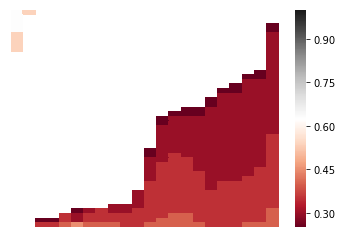

In [74]:
import math

#sns.barplot()
k = 1

sub_louv = copy(louv[louv.cluster_sub == k])
max_num_drugs = max(sub_louv.num_drugs)

num_under_local = np.sum(sub_louv.understudied&(sub_louv.num_drugs > 0))
num_not_under_local = np.sum((~sub_louv.understudied)&(sub_louv.num_drugs > 0))
num_studied = max(np.sum(sub_louv.understudied), np.sum(~sub_louv.understudied))

print(num_under_local, num_not_under_local, num_studied)

#local_heat_mat = np.zeros((len(sub_louv),math.ceil(max_num_drugs/10))) 
local_heat_mat = np.ones((num_under_local+num_not_under_local,max_num_drugs+3)) 
#alpha_heat_mat = np.zeros((num_drugged+num_under_local+num_not_under_local,max_num_drugs)) 
#display(local_heat_mat)
#display(sub_louv.sort_values(by='num_drugs', ascending=False))
for understudied_value in [True, False]:
    local_sub_louv = sub_louv[(sub_louv.understudied == understudied_value) & (sub_louv.num_drugs>0)]
    reverse=understudied_value
    offset = 0 if understudied_value else num_under_local
    for ind,row in local_sub_louv.sort_values(by=['num_drugs'], ascending= not understudied_value).reset_index().iterrows():
        sorted_deltas = [.9 - ds/10.0 for ds in sorted([selectivity_catter(d) for d in row['Drug']], reverse=not understudied_value)] if row['Drug'] is not np.nan else 0
        to_start = 0 if row['understudied'] else max_num_drugs+3-row['num_drugs'] 
        to_stop = row['num_drugs'] if row['understudied'] else max_num_drugs+3
        local_heat_mat[ind+offset,to_start:to_stop] = .9 * np.array(sorted_deltas) if row['understudied'] else 0.5 * np.array(sorted_deltas)
        #alpha_heat_mat[ind,0:row['num_drugs']] = [1 - ds/5.0 for ds in sorted([selectivity_catter(d) for d in row['Drug']])] if row['Drug'] 
        
g = sns.heatmap(local_heat_mat.transpose(), cmap=cm.RdGy, mask=local_heat_mat.transpose()==1)
g.set(xticks=[], yticks=[]);
#g.set(yscale='log')

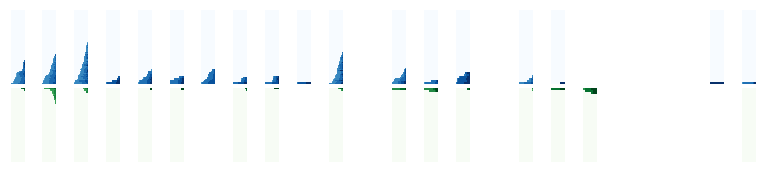

In [75]:
count = 2

fig = plt.figure(figsize=(16,10))
fig.subplots_adjust(hspace=0.05)
fig.subplots_adjust(wspace=0)

for sub_ in set(louv.cluster_sub):
    sub_louv = copy(louv[louv.cluster_sub == sub_])
    max_num_drugs = max(sub_louv.num_drugs)
    max_sub_size = 88.0

    num_under_local = np.sum(sub_louv.understudied&(sub_louv.num_drugs > 0))
    num_not_under_local = np.sum((~sub_louv.understudied)&(sub_louv.num_drugs > 0))
    num_studied = max(np.sum(sub_louv.understudied), np.sum(~sub_louv.understudied))

    #local_heat_mat = np.zeros((len(sub_louv),math.ceil(max_num_drugs/10))) 
    #local_heat_mat = np.ones((num_under_local+num_not_under_local,max_num_drugs+3)) 
    #alpha_heat_mat = np.zeros((num_drugged+num_under_local+num_not_under_local,max_num_drugs)) 
    #display(local_heat_mat)
    #display(sub_louv.sort_values(by='num_drugs', ascending=False))

    plt.tight_layout()
    fig.subplots_adjust(hspace=0.05)

    for understudied_value in [True, False]:
        local_sub_louv = sub_louv[(sub_louv.understudied == understudied_value)]
        
        if len(local_sub_louv) == 0:
            continue
        
        local_heat_mat = np.zeros((int(len(local_sub_louv)*.6+.4 * max_sub_size),max_num_drugs))

        for ind,row in local_sub_louv.sort_values(by=['num_drugs'], ascending=False).reset_index().iterrows():
            sorted_deltas = [.9 - ds/10.0 for ds in sorted([selectivity_catter(d) for d in row['Drug']], reverse=False)] if row['Drug'] is not np.nan else 0        #print(to_start, to_stop)
            local_heat_mat[ind,0:row['num_drugs']] = .9 * np.array(sorted_deltas) if row['understudied'] else 0.9 * np.array(sorted_deltas)

        cmap_local = cm.Greens if understudied_value else cm.Blues

        if not understudied_value:
            local_heat_mat = np.flip(local_heat_mat, axis=0)
            
        if local_heat_mat.shape[1] == 0:
            continue
            
        ax_cur = plt.subplot2grid((9,36),(5+1*understudied_value,sub_-1))
        g = sns.heatmap(np.flip(local_heat_mat, axis=1), cmap=cmap_local, ax=ax_cur, cbar=False)
        g.set(xticks=[], yticks=[]);

    

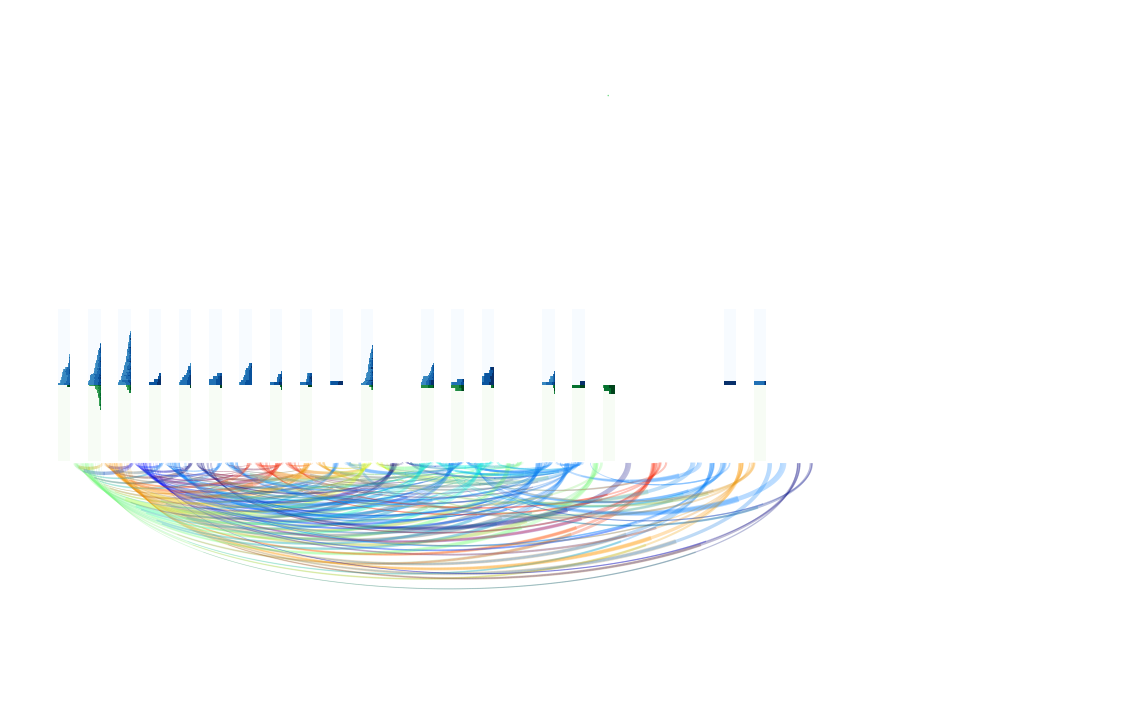

In [76]:
fig = plt.figure(figsize=(16,10))
fig.subplots_adjust(hspace=0.05)
fig.subplots_adjust(wspace=0)


### swarm plot ###
swarm_ax = plt.subplot2grid((9,36),(0,0), colspan=36, rowspan=4)
g = sns.swarmplot(x='cluster_sub', y='sub_members_hit', hue="selectivity_score", data=drug_data_ext, palette="bright", size=1.5, orient='v', alpha = .6, ax=swarm_ax)
g.set(xlim=(-1,36))
#g.set(yscale='log')
g.set(ylim=(1,None))
g.grid(False)
g.legend_.remove()
sns.despine()
swarm_ax.axis('off')
###

max_sub_size = max(louv[louv.num_drugs > 0].groupby('cluster_sub')['num_drugs'].agg(len)) + 3

for sub_ in set(louv.cluster_sub):
    sub_louv = copy(louv[louv.cluster_sub == sub_])
    max_num_drugs = max(sub_louv.num_drugs)

    num_under_local = np.sum(sub_louv.understudied&(sub_louv.num_drugs > 0))
    num_not_under_local = np.sum((~sub_louv.understudied)&(sub_louv.num_drugs > 0))
    num_studied = max(np.sum(sub_louv.understudied), np.sum(~sub_louv.understudied))

    #local_heat_mat = np.zeros((len(sub_louv),math.ceil(max_num_drugs/10))) 
    #local_heat_mat = np.ones((num_under_local+num_not_under_local,max_num_drugs+3)) 
    #alpha_heat_mat = np.zeros((num_drugged+num_under_local+num_not_under_local,max_num_drugs)) 
    #display(local_heat_mat)
    #display(sub_louv.sort_values(by='num_drugs', ascending=False))

    plt.tight_layout()
    fig.subplots_adjust(hspace=0.05)

    for understudied_value in [True, False]:
        local_sub_louv = sub_louv[(sub_louv.understudied == understudied_value)]
        
        if len(local_sub_louv) == 0:
            continue
        
        local_heat_mat = np.zeros((int(len(local_sub_louv)*.6+.4 * max_sub_size),max_num_drugs))

        for ind,row in local_sub_louv.sort_values(by=['num_drugs'], ascending=False).reset_index().iterrows():
            if ind >= max_sub_size:
                break
            
            sorted_deltas = [.9 - ds/10.0 for ds in sorted([selectivity_catter(d) for d in row['Drug']], reverse=False)] if row['Drug'] is not np.nan else 0        #print(to_start, to_stop)
            local_heat_mat[ind,0:row['num_drugs']] = .9 * np.array(sorted_deltas) if row['understudied'] else 0.9 * np.array(sorted_deltas)
            

        cmap_local = cm.Greens if understudied_value else cm.Blues

        if not understudied_value:
            local_heat_mat = np.flip(local_heat_mat, axis=0)
            
        if local_heat_mat.shape[1] == 0:
            continue
            
        ax_cur = plt.subplot2grid((9,36),(4+1*understudied_value,sub_-1))
        g = sns.heatmap(np.flip(local_heat_mat, axis=1), cmap=cmap_local, ax=ax_cur, cbar=False)
        g.set(xticks=[], yticks=[]);

#g2 = sns.swarmplot(x='cluster_sub', y="num_drugs", hue="understudied", data=louv, palette="muted", dodge=False, ax = axes[1], size=2)
root_ax = plt.subplot2grid((9,36),(6,0), colspan=36, rowspan=3)

root_ax.grid(False)
root_ax.set_ylim([-50,0])
root_ax.yaxis.set_ticks([])

plt.tight_layout()
fig.subplots_adjust(hspace=0)

#g2.set(xlim=(-1,36))
#g2.set(ylim=(-3,None))
#g2.set(yscale='log')
#g2.legend_.remove()
#g2.grid(False)

under = set(understudied.symbol)

for sub_ in subclust_connectivity.keys():
    for connect_sub in subclust_connectivity[sub_].keys():
        if connect_sub == sub_:
            continue
        
        node1_x, node1_y = (sub_-.5+1*connect_sub/26.,-.2)
        node2_x, node2_y = (connect_sub-.5+1*sub_/26.,-.2)

        num_points_between = 500#*int(np.log(np.abs(connect_sub-sub_)))

        arc_center_x = (node1_x + node2_x)/2.0
        arc_center_y = (node1_y + node2_y -.1)/2.0
        semicircle_radius = float(np.abs(node2_x - node1_x))/2.0

        arc_width_right = 10*np.sqrt(subclust_connectivity[sub_][connect_sub])
        arc_width_left = 10*np.sqrt(subclust_connectivity[connect_sub][sub_])

        line_widths = np.linspace(arc_width_right, arc_width_left, num_points_between)
        
        base_coords = np.linspace(0, 1, num_points_between)*np.pi*3/4
        #print(base_coords)
        if node1_x > node2_x:
            #continue
            x_coords = np.cos(base_coords)*semicircle_radius+arc_center_x
            #print('reverse')
        else:
            #continue
            x_coords = np.cos(base_coords+np.pi)*semicircle_radius+arc_center_x
            #base_coords = base_coords[::-1]

        #y_coords = (-np.sin(base_coords)*semicircle_radius+arc_center_y)*max(sub_,connect_sub)/18.0
        y_coords = (-np.sin(base_coords)*semicircle_radius+arc_center_y)*max(height_dict[sub_], height_dict[connect_sub])

        points = np.array([x_coords, y_coords]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)
        
        color_right = list(cm.jet_r(sub_sup_dict[sub_]/8.))
        color_left = list(cm.jet_r(sub_sup_dict[connect_sub]/8.))
        color_left[3] = 0 # set to transparent at end
        
        color_coords = np.linspace(0.0, 1.0, num_points_between)
        
        color_coords = list(zip(*[list((color_left[i]-color_right[i])*color_coords*.4+color_right[i]) if i < 3 else list((color_left[i]-color_right[i])*color_coords+color_right[i]) for i in range(4)]))
        #print(color_coords[0],color_coords[150],color_coords[290],color_coords[499])
        
    
        lc = LineCollection(segments, linewidths=line_widths,color=color_coords, alpha=.3)#, linestyles='-')


        root_ax.add_collection(lc)
    #break


root_ax.set_xlim([0,37])  
root_ax.axis('off')

#plt.savefig('subcluster_sequoia_logbranches_logtrunk2.pdf', orientation='landscape')
plt.show()
#axes[0].set_xlim([0,5])


### Sequoia Super

In [77]:
drug_data_ext_super = drug_data_ext.groupby(['cluster_super', 'Drug']).agg({'selectivity_score':np.mean, 'num_members_hit':np.mean}).reset_index()

ext = copy(drug_data_ext_super.iloc[0])
ext['cluster_super'] = 9
ext['num_members_hit'] = np.nan
ext['Drug'] = 'nan'

drug_data_ext_super = drug_data_ext_super.append(ext, ignore_index=True)

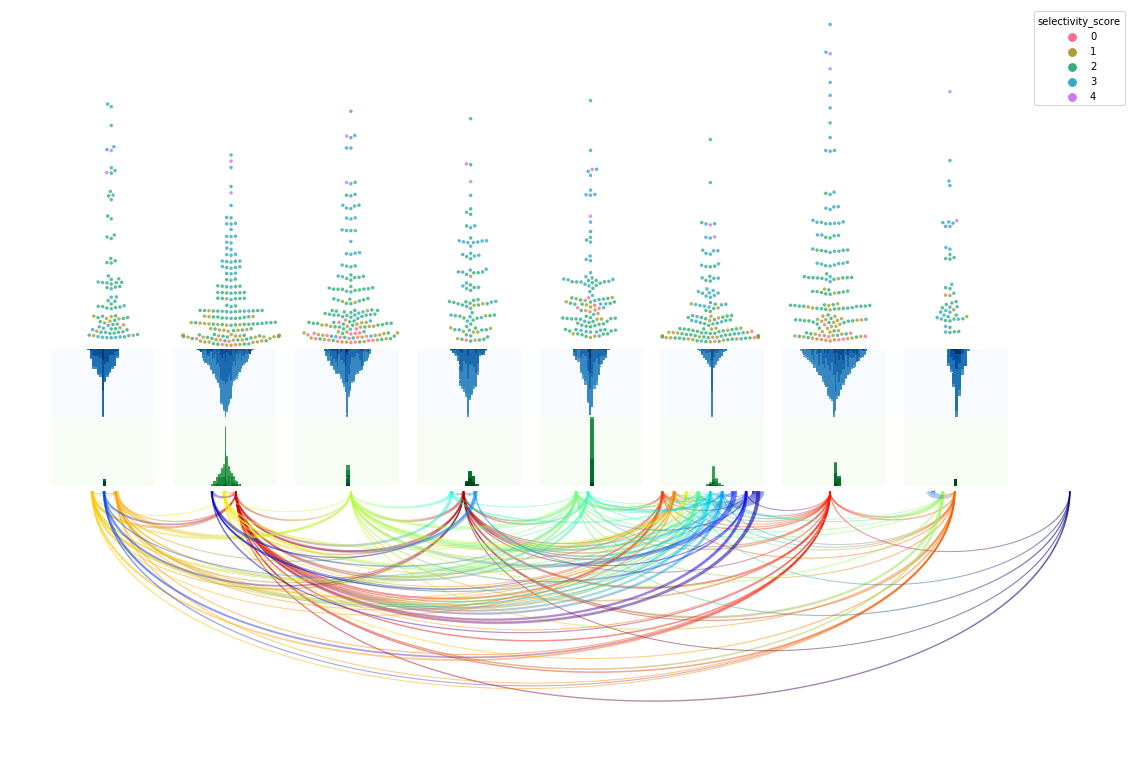

In [82]:
fig = plt.figure(figsize=(16,11))
fig.subplots_adjust(hspace=0.05)
fig.subplots_adjust(wspace=0)

### swarm plot ###
swarm_ax = plt.subplot2grid((11,9),(0,0), colspan=9, rowspan=5)
g = sns.swarmplot(x='cluster_super', y='num_members_hit', hue="selectivity_score", data=drug_data_ext_super, palette="husl", size=3.5, orient='v', alpha = .8, ax=swarm_ax)
g.set(xlim=(-.5,8.5))
#g.set(yscale='log')
g.set(ylim=(0,None))
g.grid(False)
#g.legend_.remove()
sns.despine()
swarm_ax.axis('off')
###

max_sup_size = max(louv[louv.num_drugs > 0].groupby('cluster_super')['num_drugs'].agg(len)) + 3

for sup_ in set(louv.cluster_super):
    sup_louv = copy(louv[louv.cluster_super == sup_])
    max_num_drugs = max(sup_louv.num_drugs)

    num_under_local = np.sum(sup_louv.understudied&(sup_louv.num_drugs > 0))
    num_not_under_local = np.sum((~sup_louv.understudied)&(sup_louv.num_drugs > 0))
    num_studied = max(np.sum(sup_louv.understudied), np.sum(~sup_louv.understudied))

    #local_heat_mat = np.zeros((len(sub_louv),math.ceil(max_num_drugs/10)))
    #local_heat_mat = np.ones((num_under_local+num_not_under_local,max_num_drugs+3))
    #alpha_heat_mat = np.zeros((num_drugged+num_under_local+num_not_under_local,max_num_drugs))
    #display(local_heat_mat)
    #display(sub_louv.sort_values(by='num_drugs', ascending=False))

    plt.tight_layout()
    fig.subplots_adjust(hspace=0.05)

    for understudied_value in [True, False]:
        local_sup_louv = sup_louv[(sup_louv.understudied == understudied_value)]

        if len(local_sup_louv) == 0:
            continue

        local_heat_mat = np.zeros((int(len(local_sup_louv)*.6+.4 * max_sup_size),max_num_drugs))

        for ind,row in local_sup_louv.sort_values(by=['num_drugs'], ascending=False).reset_index().iterrows():
            if ind >= max_sup_size:
                break

            sorted_deltas = [.9 - ds/10.0 for ds in sorted([selectivity_catter(d) for d in row['Drug']], reverse=False)] if row['Drug'] is not np.nan else 0        #print(to_start, to_stop)
            local_heat_mat[ind,0:row['num_drugs']] = .9 * np.array(sorted_deltas) if row['understudied'] else 0.9 * np.array(sorted_deltas)

        cmap_local = cm.Greens if understudied_value else cm.Blues

        if understudied_value:
            local_heat_mat = np.flip(local_heat_mat, axis=1)

        if local_heat_mat.shape[1] == 0:
            continue
            
        local_heat_center = np.zeros_like(local_heat_mat)
        local_heat_center[local_heat_mat.shape[0]//2:0:-1,:] = local_heat_mat[1::2,:]
        local_heat_center[local_heat_mat.shape[0]//2:,:] = local_heat_mat[::2,:]

        ax_cur = plt.subplot2grid((11,9),(5+1*understudied_value,sup_-1))
        #g = sns.heatmap(np.flip(local_heat_mat, axis=1), cmap=cmap_local, ax=ax_cur, cbar=False)
        g = sns.heatmap(np.transpose(local_heat_center), cmap=cmap_local, ax=ax_cur, cbar=False)
        g.set(xticks=[], yticks=[]);

root_ax = plt.subplot2grid((11,9),(7,0), colspan=9, rowspan=4)

root_ax.grid(False)
root_ax.set_ylim([-10,0])
root_ax.yaxis.set_ticks([])

plt.tight_layout()
fig.subplots_adjust(hspace=0)

under = set(understudied.symbol)
max_num_subclusts = max(louv.groupby('cluster_super')['cluster_sub'].agg(set).apply(len))

for sub_ in subclust_connectivity.keys():
    for connect_sub in subclust_connectivity[sub_].keys():
        if connect_sub == sub_:
            continue
            
        # this tells us the location of the current subclsuter relative to other subclusters in the supercluster
        which_sub_number = [i for i,cand_sub in enumerate(super_sub_dict[sub_sup_dict[sub_]]) if cand_sub==sub_][0]
        
        # this tells us the location of the current subcluster relative to other subclusters in the supercluster
        which_connect_sub_number = [i for i,cand_sub in enumerate(super_sub_dict[sub_sup_dict[connect_sub]]) if cand_sub==connect_sub ][0]
        
        # this tells us how many subclusters are in the present supercluster
        total_sub_in_super = len(super_sub_dict[sub_sup_dict[sub_]])
        
        # this tells us how many subclusters are in the connecting supercluster
        total_sub_in_connect_super = len(super_sub_dict[sub_sup_dict[connect_sub]])

        node1_x, node1_y = (sub_sup_dict[sub_]-.4*((total_sub_in_super+1)/2./((max_num_subclusts+1)/2.))+.8*which_sub_number/(max_num_subclusts-1.0),-.2) if total_sub_in_super > 1 else (sub_sup_dict[sub_],-.2)
        node2_x, node2_y = (sub_sup_dict[connect_sub]-.4*((total_sub_in_connect_super+1)/2./((max_num_subclusts+1)/2.))+.8*which_connect_sub_number/(max_num_subclusts-1.0),-.2) if total_sub_in_connect_super > 1 else (sub_sup_dict[connect_sub],-.2)

        num_points_between = 500
        
        arc_center_x = (node1_x + node2_x)/2.0
        arc_center_y = (node1_y + node2_y)/2.0
        semicircle_radius = float(np.abs(node2_x - node1_x))/2.0

        arc_width_right = 1+2*(6*subclust_connectivity[sub_][connect_sub])**2
        arc_width_left = 1+2*(6*subclust_connectivity[connect_sub][sub_])**2

        line_widths = np.linspace(arc_width_right, arc_width_left, num_points_between)

        base_coords = np.linspace(0, 1, num_points_between)*np.pi*3/4
        if node1_x > node2_x:
            x_coords = np.cos(base_coords)*semicircle_radius+arc_center_x
        else:
            x_coords = np.cos(base_coords+np.pi)*semicircle_radius+arc_center_x

        y_coords = (-np.sin(base_coords)*semicircle_radius)*max(height_dict[sub_], height_dict[connect_sub])+arc_center_y

        points = np.array([x_coords, y_coords]).T.reshape(-1, 1, 2)
        segments = np.concatenate([points[:-1], points[1:]], axis=1)

        color_right = list(cm.jet_r(sub_/26.))
        color_left = list(cm.jet_r(connect_sub/26.))
        
        color_right[3] = .8 # add alpha at begin
        color_left[3] = 0 # set to transparent at end

        color_coords = np.linspace(0.0, 1.0, num_points_between)

        color_coords = list(zip(*[list((color_left[i]-color_right[i])*color_coords*.4+color_right[i]) if i < 3 else list((color_left[i]-color_right[i])*color_coords+color_right[i]) for i in range(4)]))

        lc = LineCollection(segments, linewidths=line_widths,color=color_coords)#, linestyles='-')

        root_ax.add_collection(lc)

root_ax.set_xlim([0.5,9.5])

root_ax.axis('off')

plt.savefig('../viz/images/png/super_sequoia.png')
plt.savefig('../viz/images/pdf/super_sequoia.pdf', orientation='landscape')
plt.show()